# 1. Load and Preprocess Iris Dataset

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils.bayesian_clustering import dirichlet_cluster_process_4d

iris = load_iris()
data = iris.data
labels = iris.target
data = StandardScaler().fit_transform(data)

# 2. Visualize Clusters for Different Hyperparameters

Iteration 100/1000: 2 clusters
Iteration 200/1000: 2 clusters
Iteration 300/1000: 2 clusters
Iteration 400/1000: 3 clusters
Iteration 500/1000: 2 clusters
Iteration 600/1000: 2 clusters
Iteration 700/1000: 3 clusters
Iteration 800/1000: 3 clusters
Iteration 900/1000: 3 clusters
Iteration 1000/1000: 3 clusters
Iteration 100/1000: 2 clusters
Iteration 200/1000: 2 clusters
Iteration 300/1000: 2 clusters
Iteration 400/1000: 3 clusters
Iteration 500/1000: 2 clusters
Iteration 600/1000: 3 clusters
Iteration 700/1000: 2 clusters
Iteration 800/1000: 3 clusters
Iteration 900/1000: 2 clusters
Iteration 1000/1000: 2 clusters
Iteration 100/1000: 2 clusters
Iteration 200/1000: 2 clusters
Iteration 300/1000: 2 clusters
Iteration 400/1000: 3 clusters
Iteration 500/1000: 2 clusters
Iteration 600/1000: 2 clusters
Iteration 700/1000: 2 clusters
Iteration 800/1000: 2 clusters
Iteration 900/1000: 3 clusters
Iteration 1000/1000: 2 clusters


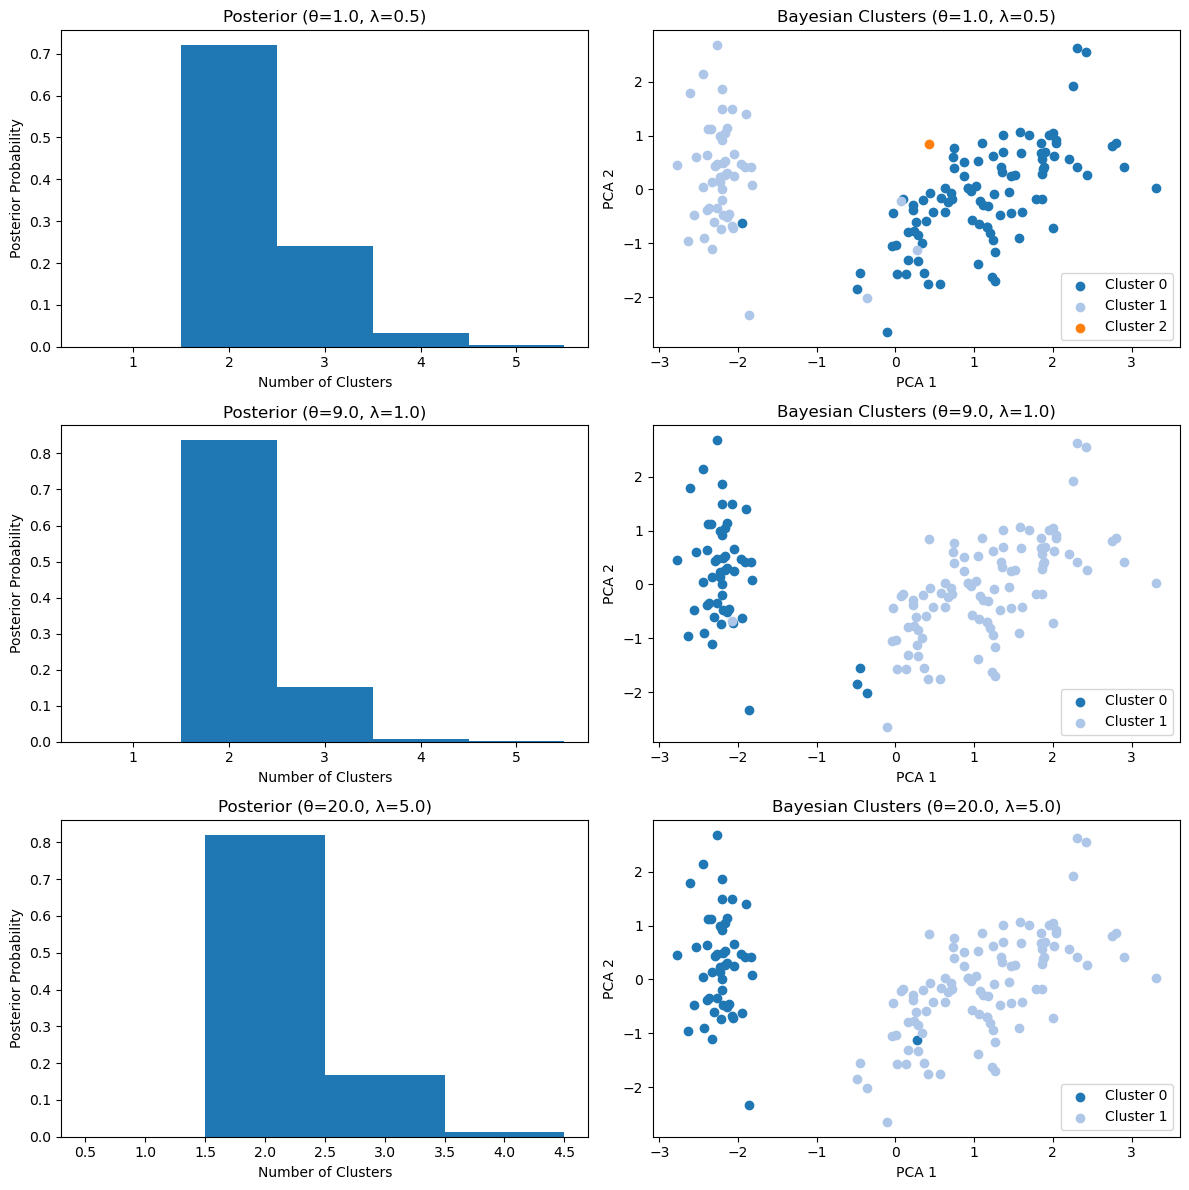

In [28]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

hyperparameter_settings = [
    {'theta': 1.0, 'lambda_': 0.5},
    {'theta': 9.0, 'lambda_': 1.0},
    {'theta': 20.0, 'lambda_': 5.0}
]

fig, axes = plt.subplots(len(hyperparameter_settings), 2, figsize=(12, 4 * len(hyperparameter_settings)))

for i, params in enumerate(hyperparameter_settings):
    theta = params['theta']
    lambda_ = params['lambda_']
    
    # Run Gibbs sampler
    n_clusters_history, cluster_assignments_history = dirichlet_cluster_process_4d(
        data, theta=theta, lambda_=lambda_, n_iter=1000, burn_in=200
    )
    
    # Get cluster assignments from the last MCMC iteration
    final_assignments = cluster_assignments_history[-1]
    unique_assignments = np.unique(final_assignments)
    assignment_to_label = {assignment: label for label, assignment in enumerate(unique_assignments)}
    final_labels = np.array([assignment_to_label[assignment] for assignment in final_assignments])
    
    # Plot posterior distribution of the number of clusters
    axes[i, 0].hist(n_clusters_history, bins=np.arange(0.5, max(n_clusters_history)+1.5), density=True)
    axes[i, 0].set_xlabel("Number of Clusters")
    axes[i, 0].set_ylabel("Posterior Probability")
    axes[i, 0].set_title(f"Posterior (θ={theta}, λ={lambda_})")
    
    # Plot Bayesian clusters
    for cluster_id in np.unique(final_labels):
        mask = (final_labels == cluster_id)
        axes[i, 1].scatter(data_2d[mask, 0], data_2d[mask, 1],
                         color=plt.cm.tab20(cluster_id), label=f'Cluster {cluster_id}')
    
    axes[i, 1].set_xlabel("PCA 1")
    axes[i, 1].set_ylabel("PCA 2")
    axes[i, 1].set_title(f"Bayesian Clusters (θ={theta}, λ={lambda_})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# 3. Frequentist Comparison: BIC with GMM

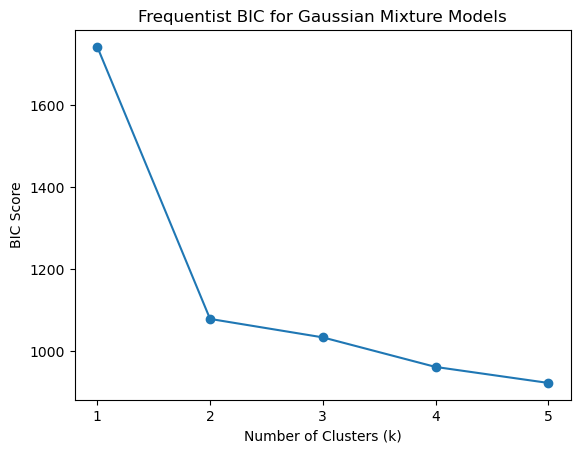

Frequentist BIC suggests 5 clusters


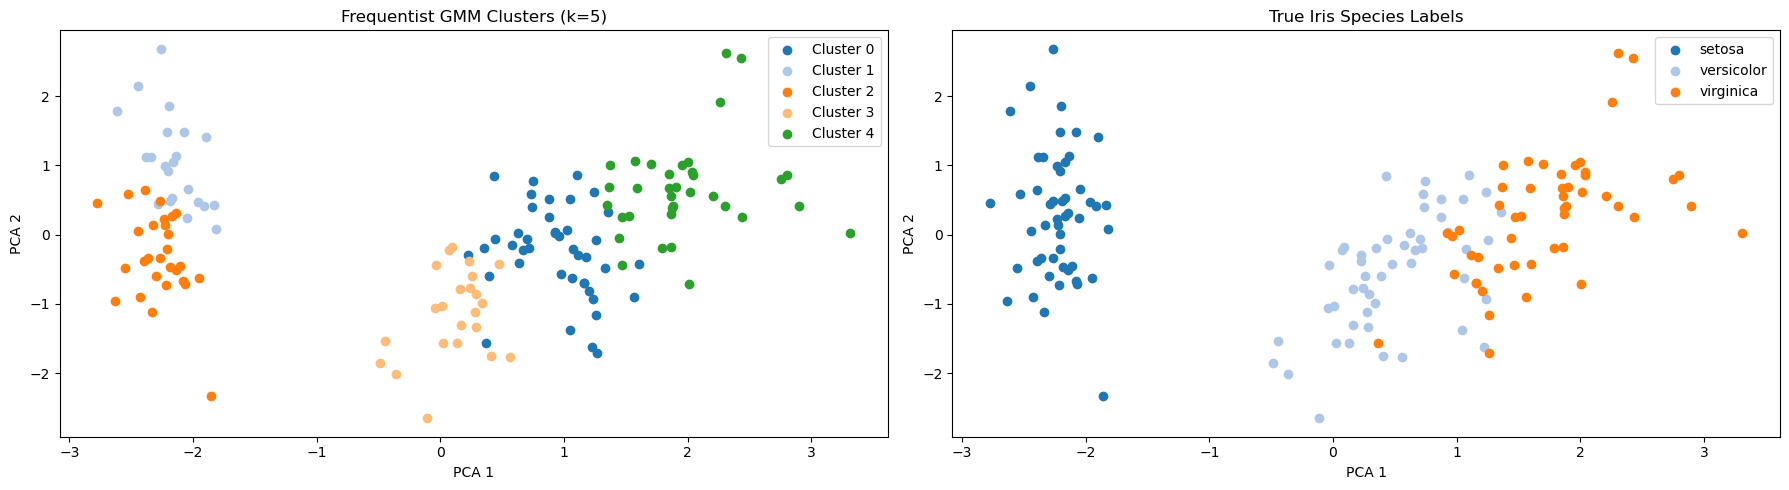

In [29]:
bic_scores = []
k_range = range(1, 6)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', random_state=42)
    gmm.fit(data)
    bic_scores.append(gmm.bic(data))

# Plot BIC
plt.plot(k_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("Frequentist BIC for Gaussian Mixture Models")
plt.xticks(k_range)
plt.show()

# Optimal k (lower BIC is better)
optimal_k = k_range[np.argmin(bic_scores)]
print(f"Frequentist BIC suggests {optimal_k} clusters")


# Visualize Clusters in 2D using PCA

# Visualize Clusters
plt.figure(figsize=(18, 5))

# Subplot 1: Frequentist GMM Clusters (BIC Result)
plt.subplot(1, 2, 1)
optimal_gmm = GaussianMixture(n_components=optimal_k, covariance_type='diag', random_state=42)
gmm_labels = optimal_gmm.fit_predict(data)
for cluster_id in range(optimal_k):
    mask = (gmm_labels == cluster_id)
    plt.scatter(data_2d[mask, 0], data_2d[mask, 1], 
                color=plt.cm.tab20(cluster_id), label=f'Cluster {cluster_id}')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"Frequentist GMM Clusters (k={optimal_k})")
plt.legend()

# Subplot 2: True Labels
plt.subplot(1, 2, 2)
for true_label in np.unique(labels):
    mask = (labels == true_label)
    plt.scatter(data_2d[mask, 0], data_2d[mask, 1], 
                color=plt.cm.tab20(true_label), label=iris.target_names[true_label])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("True Iris Species Labels")
plt.legend()

plt.tight_layout()
plt.show()